In [ ]:
import os
import sys
import time
import datetime
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms
import glob


!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Seoul /etc/localtime

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Autoreload in case that the custom modules are changed
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [ ]:
filepath = "/content/drive/MyDrive/Machine_learning/Final_project"

sys.path.append(filepath)

from util import *
from model_baseline import *

In [ ]:
# Class information
classes = ['background',
'aeroplane',
'bicycle',
'boat',
'bus',
'car',
'motorbike',
'person',
'train',
'boundary'] # For convenience, the classes are denoted as corresponding indexes (0~9) in this script.
# We ignore the boundary class (index : 9) in this project!

image_transform = transforms.ToPILImage() # converting Torch.tensor -> PIL format

# You can freely add or modify any transform functions,
# except ToTensor, ToLabel, Relabel functions (again, do not change!).

common_transform = []

input_transform = [transforms.ToTensor()]

target_transform = [ToLabel(),
    Relabel(4, 3),
    Relabel(6, 4),
    Relabel(7, 5),
    Relabel(14, 6),
    Relabel(15, 7),
    Relabel(19, 8),
    Relabel(255, 9),
]

input_transform = transforms.Compose(common_transform + input_transform)
target_transform = transforms.Compose(common_transform + target_transform)

In [ ]:
# You can modify the loss, the model and the optimizer
criterion = nn.CrossEntropyLoss(ignore_index=9).cuda() # Ignore the index 9 indiciating 'boundaries' for calculating loss
model = UNet().cuda()
experiment = "exp_colab"

os.makedirs(f"{filepath}/{experiment}/eval_result", exist_ok=True)

model.load_state_dict(torch.load(f"{filepath}/{experiment}/best_model_state_dict.pt"))

model.eval()

print("Loaded.")

Loaded.


In [ ]:
# Specify the path of evaluation data folder.
evaldata_path = "/content/drive/MyDrive/Machine_learning/Final_project/CoE202Spring_finalproject_test_dataset"
eval_paths = glob.glob(f"{evaldata_path}/*.jpg")

[[  0   0   0]
 [255 127  14]
 [ 44 160  44]
 [214  39  40]
 [148 103 189]
 [140  86  75]
 [227 119 194]
 [127 127 127]
 [188 189  34]
 [ 23 190 207]]


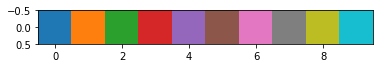

In [ ]:
# Make color palette for visualization. Image will be saved containing [0, 1, ... 9] labels. With this palette, we can view with color for corresponding label.
import matplotlib.pyplot as plt

squares = torch.arange(10).unsqueeze(0)
plt.imshow(squares.numpy(), cmap='tab10')
a = plt.get_cmap('tab10')

colors = torch.zeros(10, 3)
for i in range(1, 10):
    colors[i, :] = torch.tensor(list(a(i)[:3]))
colors = colors * 255
colors = colors.int().numpy().astype("uint8")
print(colors)

### **Coloring example**

Total number of images : 1000


Text(0.5, 0.98, 'Sample images')

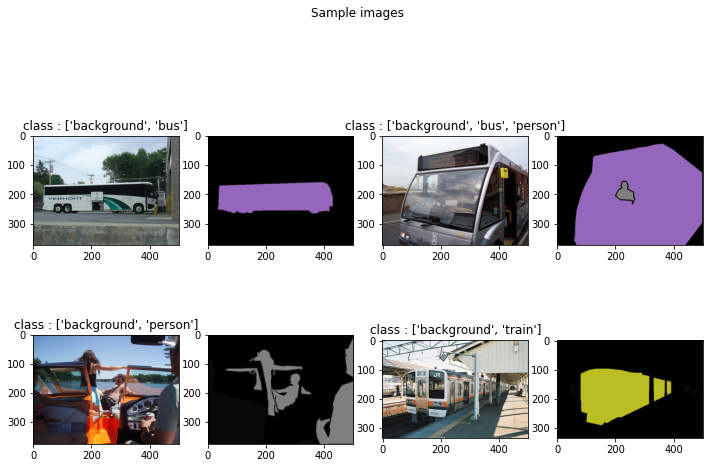

In [ ]:
# Because we will use except boundary
colors = colors[:9]

dataset = CoE_Dataset(root=f"{filepath}/CoE202Spring_finalproject_dataset", # root should be the path of your test dataset
                input_transform=input_transform,
                target_transform=target_transform)



print('Total number of images : {}'.format(len(dataset)))


# ------------
# Load dataset
# ------------

loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=1,
                                    shuffle=True,
                                    drop_last=True
                                    )

fig = plt.figure(figsize=(12, 14))
for i in range(2):
    for j in range(2):
        (sample_batch, sample_label, _) = next(iter(loader))
        fig.add_subplot(4, 4, (i * 4 + j * 2 + 1))
        plt.imshow(sample_batch[0].permute(1, 2, 0))
        classes_name = [classes[index] for index in torch.unique(sample_label[0]) if not index == 9]
        plt.title('class : ' + str(classes_name))
        fig.add_subplot(4, 4, (i * 4 + j * 2 + 1+ 1))

        r = Image.fromarray(sample_label[0][0].byte().cpu().numpy())
        r.putpalette(colors)
        r.convert('RGB')
        plt.imshow(r)
plt.suptitle("Sample images")

### **EVALUATION**

In [ ]:
# We will iterate the evaluation data and inference with loaded model.
# Predicted images will save in this path. "{filepath}/{experiment}/eval_result/"

# Because we will use except boundary
colors = colors[:9]

for eval_path in eval_paths:
    name = eval_path.split('/')[-1].split('.')[0]
    img = Image.open(eval_path)
    img = input_transform(img).unsqueeze(0)
    print(f"name : {name}, Size : {img.size()}")

    img = img.cuda()
    pred = model(img)

    pred = pred[0].max(0)[1].unsqueeze(0).detach()

    r = Image.fromarray(pred[0].byte().cpu().numpy())
    r.putpalette(colors)
    r.save(f"{filepath}/{experiment}/eval_result/{name}.png")


name : 3233569452, Size : torch.Size([1, 3, 333, 500])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3672: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


name : 3231561439, Size : torch.Size([1, 3, 335, 500])
name : 3245568131, Size : torch.Size([1, 3, 330, 500])
name : 3232564103, Size : torch.Size([1, 3, 333, 500])
name : 3231560638, Size : torch.Size([1, 3, 176, 500])
name : 3232560824, Size : torch.Size([1, 3, 333, 500])
name : 3245567346, Size : torch.Size([1, 3, 375, 500])
name : 3233567144, Size : torch.Size([1, 3, 375, 500])
name : 3233569085, Size : torch.Size([1, 3, 500, 375])
name : 3233560983, Size : torch.Size([1, 3, 375, 500])
name : 3244569727, Size : torch.Size([1, 3, 362, 500])
name : 3244568741, Size : torch.Size([1, 3, 336, 448])
name : 3244569820, Size : torch.Size([1, 3, 331, 500])
name : 3245567427, Size : torch.Size([1, 3, 375, 500])
name : 3244561731, Size : torch.Size([1, 3, 500, 333])
name : 3231560370, Size : torch.Size([1, 3, 500, 398])
name : 3232560163, Size : torch.Size([1, 3, 375, 500])
name : 3244568103, Size : torch.Size([1, 3, 500, 375])
name : 3231569166, Size : torch.Size([1, 3, 333, 500])
name : 323

In [ ]:
# While we can see the images with color, actual value of the image is within [0~8] value.
C = np.array(Image.open(f"{filepath}/{experiment}/eval_result/{name}.png").convert('P'))
np.unique(C)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)